<a href="https://colab.research.google.com/github/Mafaz03/Test-Checkpoints/blob/main/MIDaS_lidar_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Importing Dependancies

In [ ]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
import os
from pathlib import Path
import requests
import zipfile

In [ ]:
try:
  import timm
except:
  !pip install timm -q
  import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.8 MB/s eta 0:00:00


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo -q
  from torchinfo import summary

#2 Setting device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#3 Downloading model

In [ ]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS" , model_type)
midas.to(device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:18<00:00, 74.3MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
summary(midas)

Layer (type:depth-idx)                             Param #
DPTDepthModel                                      --
├─Module: 1-1                                      --
│    └─VisionTransformer: 2-1                      591,872
│    │    └─PatchEmbed: 3-1                        787,456
│    │    └─Dropout: 3-2                           --
│    │    └─Identity: 3-3                          --
│    │    └─Identity: 3-4                          --
│    │    └─Sequential: 3-5                        302,309,376
│    │    └─LayerNorm: 3-6                         2,048
│    │    └─Identity: 3-7                          --
│    │    └─Dropout: 3-8                           --
│    │    └─Linear: 3-9                            1,025,000
│    └─Sequential: 2-2                             --
│    │    └─ProjectReadout: 3-10                   2,098,176
│    │    └─Transpose: 3-11                        --
│    │    └─Unflatten: 3-12                        --
│    │    └─Conv2d: 3-13                 

#4 Setting transformers

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")
transforms = midas_transforms.dpt_transform
transforms

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7f83fbb3af80>
    <function transforms.<locals>.<lambda> at 0x7f83fbb3b010>
)

#5 Importing Datasets

In [ ]:
data_path = Path("data/")
image_path = data_path / "random_images"

image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "360_1.zip", "wb") as f:
  request = requests.get("https://github.com/Mafaz03/Datasets/raw/main/360/360-1.jpg.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / "360_1.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)



In [ ]:
three60_img = cv.imread("/content/data/random_images/360-1.jpg")
three60_img = cv.cvtColor(three60_img, cv.COLOR_BGR2RGB)
size = three60_img.shape[:2]

size_factor = 2

cv.resize(three60_img , (int(size[1]/size_factor) , int(size[0]/size_factor)))

array([[[212, 215, 220],
        [212, 215, 220],
        [212, 215, 220],
        ...,
        [213, 216, 223],
        [213, 216, 223],
        [212, 215, 222]],

       [[212, 215, 220],
        [212, 215, 220],
        [213, 216, 221],
        ...,
        [213, 216, 223],
        [212, 215, 222],
        [212, 215, 222]],

       [[212, 215, 222],
        [213, 216, 223],
        [212, 215, 222],
        ...,
        [213, 216, 223],
        [212, 215, 222],
        [212, 215, 222]],

       ...,

       [[141, 138, 131],
        [143, 140, 133],
        [140, 137, 131],
        ...,
        [141, 136, 132],
        [143, 138, 134],
        [144, 139, 135]],

       [[139, 136, 129],
        [140, 137, 130],
        [138, 135, 130],
        ...,
        [136, 131, 127],
        [140, 135, 131],
        [143, 138, 134]],

       [[139, 136, 129],
        [140, 137, 130],
        [141, 138, 133],
        ...,
        [142, 137, 133],
        [144, 139, 135],
        [142, 137, 133]]

(-0.5, 9931.5, 2074.5, -0.5)

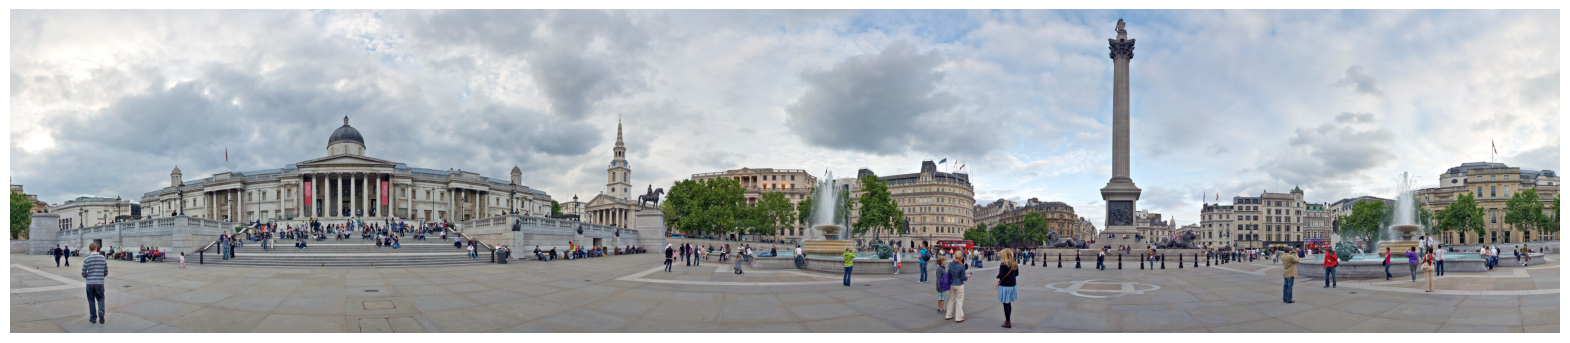

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(three60_img)
plt.axis("off")

In [ ]:
input_transformed = transforms(three60_img).to(device)
input_transformed.shape

torch.Size([1, 3, 384, 1824])

#6 Predicting

In [ ]:
with torch.no_grad():
  prediction = midas(input_transformed)

  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size = three60_img.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  depth_map = prediction.cpu().numpy()
  depth_map = cv.normalize(depth_map , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)

  depth_map = (depth_map*255).astype(np.uint8)
  depth_map = cv.applyColorMap(depth_map , cv.COLORMAP_MAGMA)

#7 Visualizing

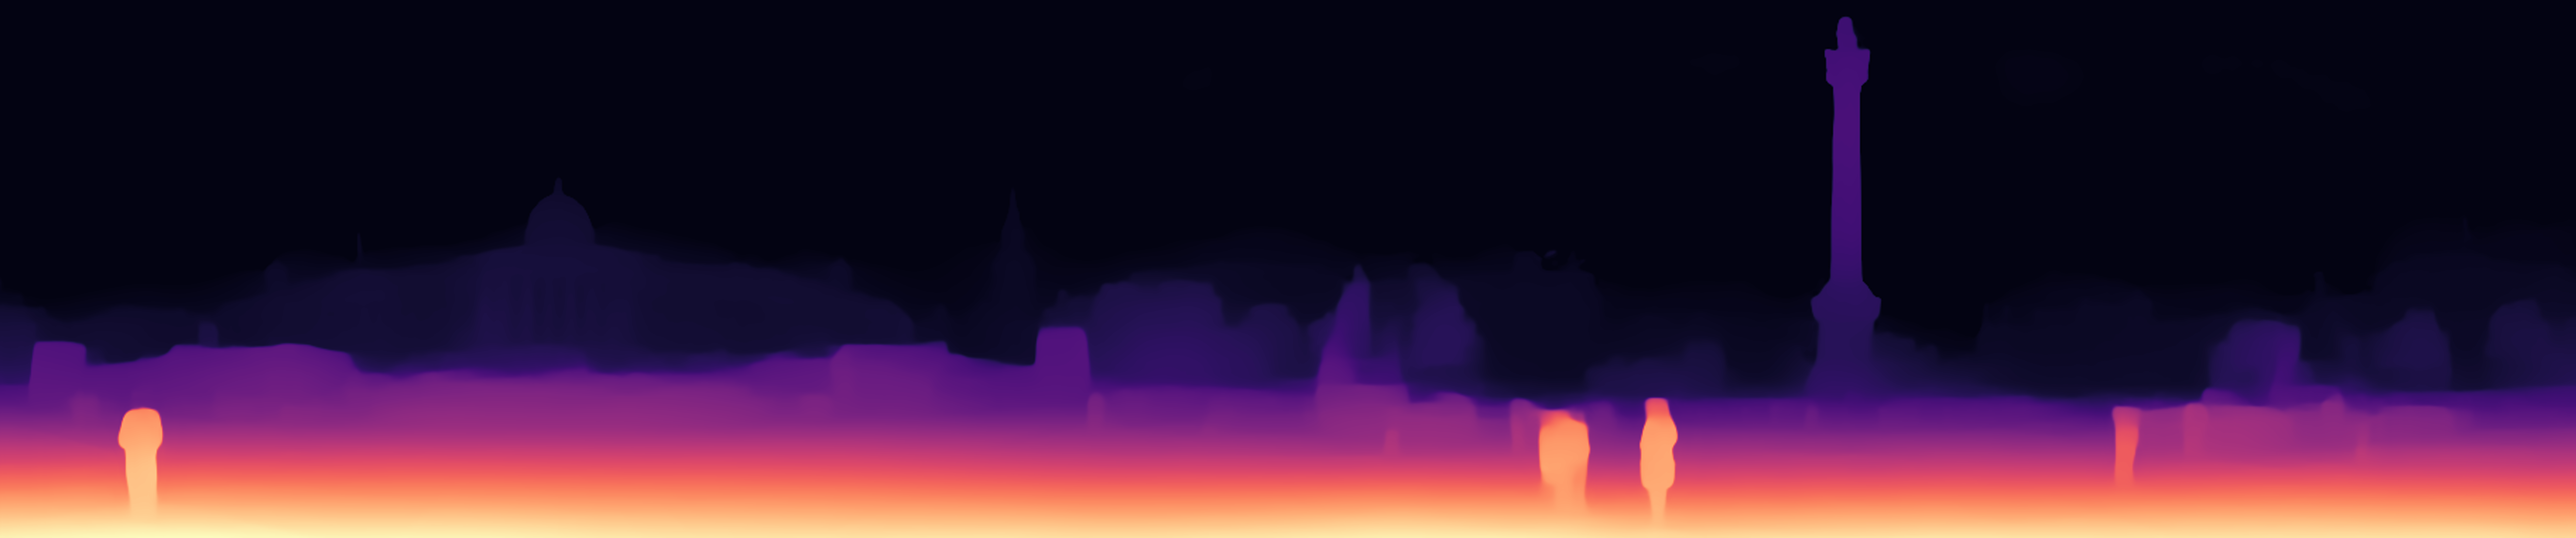

In [ ]:
cv2_imshow(depth_map)

In [ ]:
size = three60_img.shape[:2]
size

(2075, 9932)

(-0.5, 9831.5, 2024.5, -0.5)

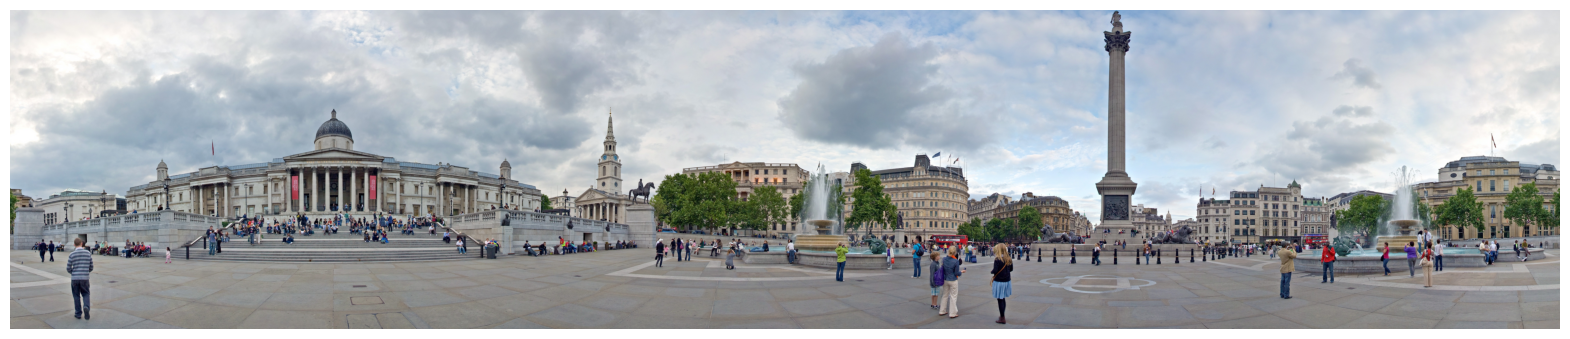

In [ ]:
plt.figure(figsize = (20,20))
three60_img_squeezed = three60_img[50 : size[0] ,  100: size[1] ]
plt.imshow(three60_img_squeezed)
plt.axis("off")

(500, 7857, 3)


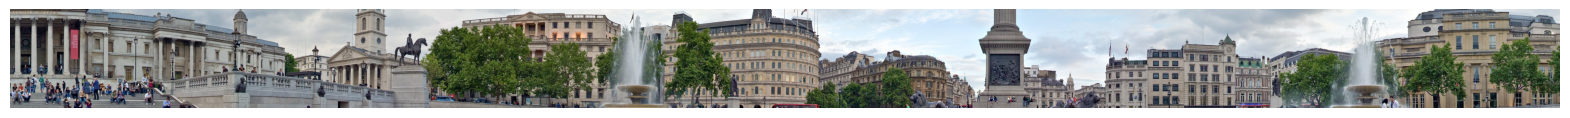

In [ ]:
plt.figure(figsize = (20,20))
three60_img_squeezed = three60_img[ 1000 : 1500 ,  size[0] : size[1] ]
plt.imshow(three60_img_squeezed)
plt.axis("off")
print(three60_img_squeezed.shape)

In [ ]:
input_transformed_squeezed = transforms(three60_img_squeezed).to(device)
input_transformed_squeezed.shape

torch.Size([1, 3, 384, 6048])

In [ ]:
three60_img_squeezed.shape[:2]

(500, 7857)

In [ ]:
with torch.no_grad():
  prediction = midas(input_transformed)

  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size = three60_img.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_squeezed = prediction[ 1000 : 1500 ,  size[0] : size[1] ]

  depth_map_squeezed = prediction_squeezed.cpu().numpy()
  depth_map_squeezed = cv.normalize(depth_map_squeezed , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_data = depth_map_squeezed

  depth_map_squeezed = (depth_map_squeezed*255).astype(np.uint8)
  depth_map_squeezed = cv.applyColorMap(depth_map_squeezed , cv.COLORMAP_MAGMA)

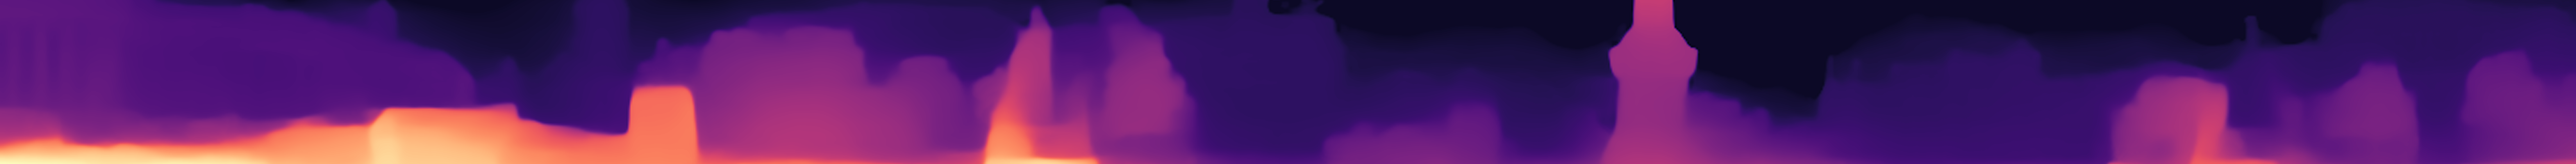

In [ ]:
cv2_imshow(depth_map_squeezed)

In [ ]:
prediction.shape #Original shape of the image / Prediction

torch.Size([2075, 9932])

In [ ]:
size_squeezed = list(depth_map_squeezed.shape) #Normalized section of the Prediction
size_squeezed

[500, 7857, 3]

In [ ]:
def segments(amount : int , width : int) -> list[tuple[int]]:

  slice_list = []
  amount = 10

  sections = width // amount

  beg = sections
  temp = 0
  for batches in range(amount):
    section = sections + temp

    if batches == 0:
      print( 0 , section)
      slice_list.append((0 , sections))
    else:
      print(beg , beg + sections)
      slice_list.append((beg , beg + sections))
      beg += sections

  return slice_list

In [ ]:
seg = segments(amount = 10 , width = size_squeezed[1])

0 785
785 1570
1570 2355
2355 3140
3140 3925
3925 4710
4710 5495
5495 6280
6280 7065
7065 7850


In [ ]:
cropped_rgb = cv.cvtColor(depth_map_squeezed, cv.COLOR_BGR2RGB)

1.0
0.9283374701761434
0.7987776784589903
0.9151618163473894
0.925095248267512
0.3840719626607633
0.5638409277958957
0.3679680914443688
0.6597199646417744
0.52736636405365


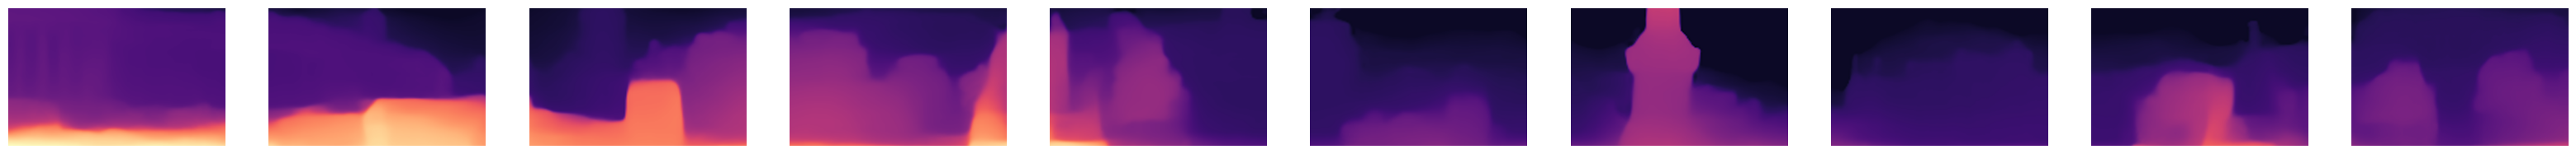

In [ ]:
brightest_points = {}

plt.figure(figsize = (40,45))
for segments in range(len(seg)):
  plt.subplot(1 , len(seg) , segments + 1)
  cropped = cropped_rgb[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data = depth_map_data[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point = np.max(cropped_data)
  brightest_points[segments + 1] = round(brightest_point , 2)
  print(brightest_point)
  plt.imshow(cropped)
  plt.axis("off")

In [ ]:
brightest_points

{1: 1.0,
 2: 0.93,
 3: 0.8,
 4: 0.92,
 5: 0.93,
 6: 0.38,
 7: 0.56,
 8: 0.37,
 9: 0.66,
 10: 0.53}

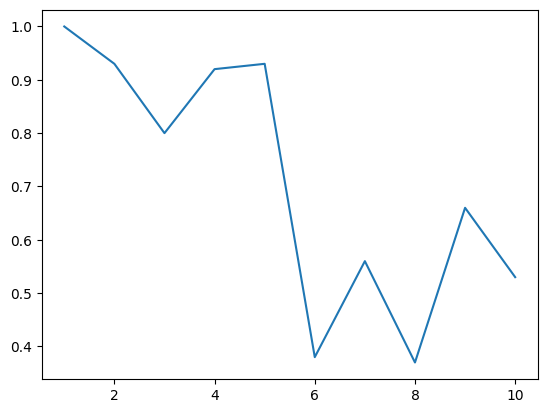

In [ ]:
plt.plot(brightest_points.keys() , brightest_points.values())

In [ ]:
brightest_points.values()

dict_values([1.0, 0.93, 0.8, 0.92, 0.93, 0.38, 0.56, 0.37, 0.66, 0.53])

In [ ]:
def plor_plot(brightest_points : dict , title : str , marker):
  ax = plt.subplot(111 , projection = "polar")
  ax.set_rmax(1)
  ax.set_rlabel_position(0)
  degrees= 360/len(brightest_points)
  theta=np.deg2rad(np.arange(0,361,degrees))[1:]
  theta = np.append(theta , theta[0])
  brightest_points[len(brightest_points)+1] = list(brightest_points.values())[0]
  ax.plot(theta , brightest_points.values() , marker = marker)
  plt.title(title)

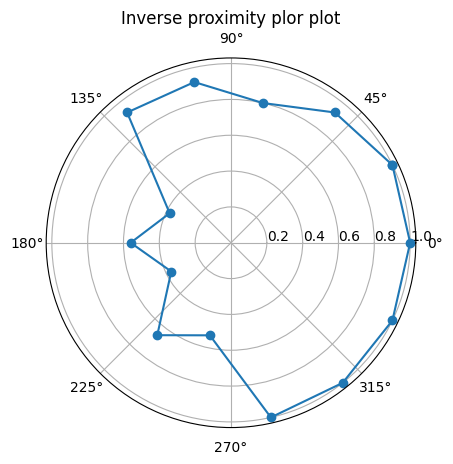

In [ ]:
plor_plot(brightest_points , title = "Inverse proximity plor plot" , marker = "o") #closest proximity value is higher

In [ ]:
brightest_points_normal = {}

for i in range(1 , len(brightest_points) + 1 ):
  brightest_points_normal[i] = round(1 - brightest_points[i] , 2)

In [ ]:
brightest_points_normal

{1: 0.0,
 2: 0.07,
 3: 0.2,
 4: 0.08,
 5: 0.07,
 6: 0.62,
 7: 0.44,
 8: 0.63,
 9: 0.34,
 10: 0.47,
 11: 0.0,
 12: 0.0}

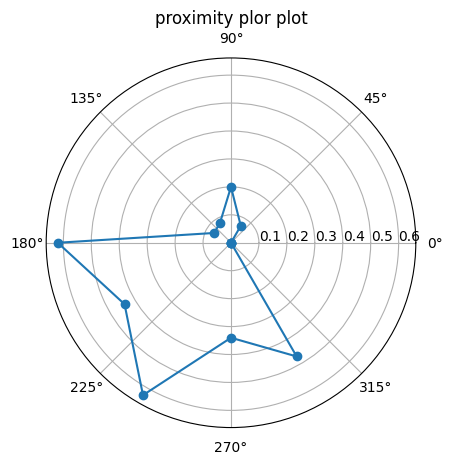

In [ ]:
plor_plot(brightest_points_normal , title = "proximity plor plot" , marker = "o") #closest proximity value is lower